# Analyze Weights&Bias Hyperparameter Search Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from scipy.stats import kruskal
import os
from  pathlib import Path
from scikit_posthocs import posthoc_dunn

In [2]:
project_root = "../.."
plot_path = os.path.join(project_root, "results", "experiments", "pretrained_models")
Path(plot_path).mkdir(exist_ok=True, parents=True)

In [3]:
change_runs = {
    "node_type": {
        "pretrained_model": {
            "Binding_DDG": "residue",
            "DeepRefine": "atom"
        }
    },
    "learning_rate": {
        "batch_size": "divide"
    },
    "batch_size": {
        "node_type": {
            "atom": ("divide", 5)
        }
    },    
    "max_num_nodes": {
        "node_type": {
            "atom": ("multiply", 5)
        }
    }
    
}

remove_runs = {
    "attention_heads": {
        "layer_type": "GCN",
        "num_gnn_layers": 0
    },
    "gnn_type": {
        "num_gnn_layers": 0
    },
    "channel_halving": {
        "num_gnn_layers": 0
    },
    "channel_doubling": {
        "num_gnn_layers": 0
    },
    
}

def change_value(row: pd.Series, original_col: str, adaption_dict: Dict):
    for key, adaptions in adaption_dict.items():
        if isinstance(adaptions, str):
            if adaptions == "divide":
                row[original_col] / row[key]
        elif isinstance(adaptions, Dict) and key in row and row[key] in adaptions:
            if isinstance(adaptions[row[key]], str):
                return adaptions[row[key]]
            elif isinstance(adaptions[row[key]], Tuple):
                if adaptions[row[key]][0] == "divide":
                    row[original_col] / adaptions[row[key]][1]
                elif adaptions[row[key]][0] == "multiply":
                    row[original_col] * adaptions[row[key]][1]
    
    return row[original_col]


def remove_rows(row: pd.Series, original_col: str, remove_dict: Dict):
    for key, value in remove_dict.items():
        if row[key] == value:
            return False

    return True


def select_df(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None):
    if x_min is not None:
        df = df[df[target] >= x_min].copy()
    if x_max is not None:
        df = df[df[target] <= x_max].copy()
    
    for col, adaption in change_runs.items():
        if group != col:
            continue
        df[col] = df.apply(lambda row: change_value(row, col, adaption), axis=1)
    for col, remove in remove_runs.items():
        if group != col:
            continue
        df = df[df.apply(lambda row: remove_rows(row, col, remove), axis=1)].copy()
        
    df = df[["Name", target, group]]

    return df[["Name", target, group]]


def plot_box_plot(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None, axis = None):
    order = df[df[target] <= 2].groupby(by=[parameter])[target].median().sort_values().index
    mapping = {
        target: " ".join([x.capitalize() for x in target.split(":")[1].split("_")]) + " [-log(Kd)]",
        group: " ".join([x.capitalize() for x in group.split("_")])
    }
    df = select_df(df, target, group, x_min, x_max)
    df = df.rename(mapping, axis=1, copy=True)
    

    
    if axis is not None:
        sns.boxplot(data=df, y=mapping[target], x=mapping[group], ax=axis, order=order)
    else:
        sns.boxplot(data=df, y=mapping[target], x=mapping[group], order=order)


def calc_kruskal_wallis_score(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None):
    mapping = {
            target: " ".join([x.capitalize() for x in target.split(":")[1].split("_")]),
            group: " ".join([x.capitalize() for x in group.split("_")])
    }
    df = select_df(df, target, group, x_min, x_max)
    df = df.rename(mapping, axis=1)

    group_values = []
    results = []

    groups = df.groupby(mapping[group]).groups

    for value, idx in groups.items():
        group_values.append(value)
        results.append(df.loc[idx, mapping[target]])

    kruskal_results = kruskal(*results)
    print(f"Kruskal results for parameter {mapping[group]}: H={kruskal_results[0]}, p_value={kruskal_results[1]}  ")

    #if kruskal_results[1] < 0.05:
    # perform posthoc analyis
    posthoc_results = posthoc_dunn(df, val_col=mapping[target], group_col=mapping[group])
    print("\tResults of Posthoc analysis with Bonferri correction")
    print(posthoc_results < 0.05)
        
    return kruskal_results, group_values

In [4]:
TARGET_VALUE = "abag_affinity:absolute_val_rmse"

## Exploratory Hyperparameter Search

In [5]:
exploratory_filepath = "/home/fabian/Desktop/Uni/Masterthesis/ag_binding_affinity/results/pretrained_model_results.csv"
exploratory_df = pd.read_csv(exploratory_filepath)
exploratory_df["pretrained_model"] = exploratory_df["pretrained_model"].fillna("No-Model")
exploratory_df

,Name,Runtime,Created,State,abag_affinity:absolute_val_loss,abag_affinity:absolute_val_corr,abag_affinity:absolute_val_rmse,batch_size,max_num_nodes,num_fc_layers,num_gnn_layers,channel_halving,gnn_type,layer_type,aggregation_method,attention_heads,pretrained_model
0,iconic-sweep-19,1299,2023-01-23T12:10:14.000Z,finished,5.281305e-03,0.468967,1.235434e+00,1,None,5,3,True,guided,GCN,mean,3,No-Model
1,crimson-sweep-43,2017,2023-01-23T14:50:33.000Z,finished,5.663753e-02,0.455619,1.254833e+00,1,None,5,3,False,guided,GCN,max,3,DeepRefine
2,exalted-sweep-54,3308,2023-01-24T11:13:50.000Z,finished,5.654036e-02,0.442086,1.269944e+00,1,50,1,0,True,proximity,GAT,mean,1,DeepRefine
3,astral-sweep-69,987,2023-01-24T14:16:41.000Z,finished,1.669447e+00,0.461917,1.292071e+00,1,50,5,5,True,guided,GCN,mean,3,No-Model
4,logical-sweep-62,1646,2023-01-24T12:51:00.000Z,finished,1.697206e+00,0.322147,1.302769e+00,1,10,5,0,False,guided,GCN,attention,3,No-Model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,dry-sweep-12,3013,2023-01-23T11:17:06.000Z,finished,6.098822e+19,-0.001243,1.344999e+10,10,10,10,5,True,proximity,GAT,max,5,DeepRefine
107,fiery-sweep-105,109,2023-01-24T19:49:06.000Z,finished,NaN,NaN,NaN,1,50,10,5,True,proximity,GCN,mean,3,DeepRefine
108,hopeful-sweep-24,73,2023-01-23T12:54:24.000Z,finished,NaN,NaN,NaN,5,10,5,5,True,proximity,GAT,attention,5,DeepRefine
109,legendary-sweep-22,81070,2023-01-23T12:42:37.000Z,failed,NaN,NaN,NaN,10,10,10,5,False,proximity,GAT,edge,5,Binding_DDG


In [6]:
hyperparameters = ["pretrained_model"]
#hyperparameters = [col for col in exploratory_df.columns if ":" not in col and col not in ["Name", "Runtime", "Created","State"] + non_categorical_hyperparameters]
hyperparameters

['pretrained_model']

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
exploratory_df[exploratory_df[TARGET_VALUE] <= 2].groupby(by="pretrained_model")[TARGET_VALUE].describe()

,count,mean,std,min,25%,50%,75%,max
pretrained_model,,,,,,,,
Binding_DDG,35.00,1.44,0.13,1.34,1.37,1.38,1.41,1.88
DeepRefine,24.00,1.44,0.14,1.25,1.38,1.39,1.43,1.79
No-Model,31.00,1.42,0.12,1.24,1.36,1.39,1.41,1.85


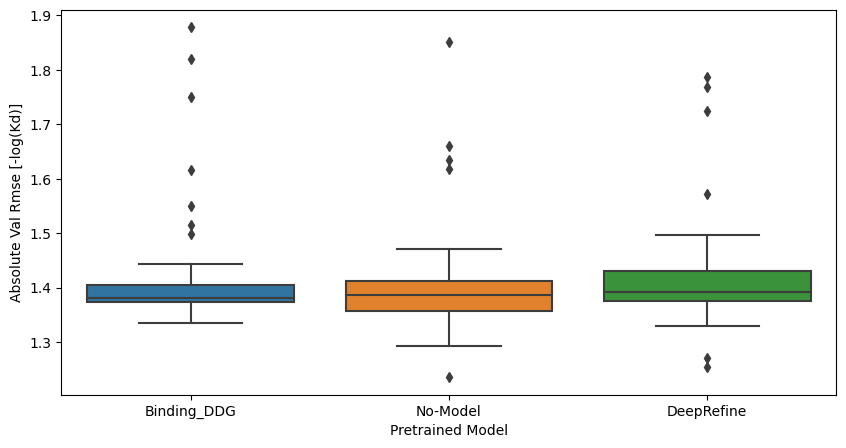

In [8]:
cols = 1
rows = int(len(hyperparameters) / cols)

fig, axs = plt.subplots(figsize=(10,rows * 5), nrows=rows, ncols=cols)

for i, parameter in enumerate(hyperparameters):
    ii = int(i / cols)
    jj = i % cols
    if cols == 1:
        plot_box_plot(exploratory_df, TARGET_VALUE, parameter, x_min=None, x_max=2)

    else:
        ax = axs[ii, jj]
        plot_box_plot(exploratory_df, TARGET_VALUE, parameter, x_min=None, x_max=2, axis=ax)

plt.savefig(os.path.join(plot_path, "pretrained_model_box_plot.png"))
plt.show()

In [9]:
rows = []

for i, parameter in enumerate(hyperparameters):
    (h, p), parameter_values = calc_kruskal_wallis_score(exploratory_df, TARGET_VALUE, parameter, x_min=None, x_max=10000000)
    rows.append({
        "Hyperparameter": parameter,
        "Values": parameter_values,
        "Kruskal H-score": h,
        "Kruskal p_value": p,
        "significant_difference": p < 0.05
    })
    print()
    
parameter_comparison_df = pd.DataFrame(rows)

Kruskal results for parameter Pretrained Model: H=1.9934663902591296, p_value=0.3690831966682129  
	Results of Posthoc analysis with Bonferri correction
             Binding_DDG  DeepRefine  No-Model
Binding_DDG        False       False     False
DeepRefine         False       False     False
No-Model           False       False     False



In [10]:
parameter_comparison_df

,Hyperparameter,Values,Kruskal H-score,Kruskal p_value,significant_difference
0,pretrained_model,"[Binding_DDG, DeepRefine, No-Model]",1.99,0.37,False


In [11]:
print(parameter_comparison_df.to_latex(index=False,escape=True))

\begin{tabular}{llrrl}
\toprule
  Hyperparameter &                              Values &  Kruskal H-score &  Kruskal p\_value &  significant\_difference \\
\midrule
pretrained\_model & [Binding\_DDG, DeepRefine, No-Model] &             1.99 &             0.37 &                   False \\
\bottomrule
\end{tabular}

